## Import libraries


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel, BertConfig, BertTokenizerFast
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt

## Import Data

In [3]:
#Read data
df=pd.read_csv('/flush5/sou090/01 - Project/c-9/data.csv')

#Split data
train_df, test_df = train_test_split(df, test_size=0.1)

print(train_df.size, test_df.size)

46695 5190


In [4]:
ex_len = []
for i in train_df['text']:
  ex_len.append(len(i.split()))
print('max length of text: ', max(ex_len), 'words')

max length of text:  134 words


## Tokenize

In [5]:
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(bert_model)

In [6]:
# Encoder the function to tokenize the data
def encoder(df, tokenizer, label = 'text', maxLen = 210):
    input_id = []
    token_type = []
    attention_mask = []
    for i in df[label].values:
        token = tokenizer(i, max_length = maxLen, truncation = True, padding = 'max_length', add_special_tokens = True)
        input_id.append(token['input_ids'])
        token_type.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    return np.array(input_id), np.array(token_type), np.array(attention_mask)

In [7]:
#Call the function to tokenize data
train_d = encoder(train_df, tokenizer)
test_d = encoder(test_df, tokenizer)

# Config of Bert

In [8]:
model_config = BertConfig.from_pretrained(bert_model)

In [9]:
model_config.output_hidden_states = True
model_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Parameters

In [10]:
bert = TFBertModel.from_pretrained(bert_model, config = model_config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
# tunable parameters
max_len = 210
#fix learning_rate
learning_rate = 1e-4
epochs = 3

#try to freeze layers

# callbacks
ckpt_dir = 'ckpt{epoch:02d}.h6'
ckpt = ModelCheckpoint(
    filepath = ckpt_dir,
    save_freq = 'epoch',
    save_weights_only=True)

optimizer = Adam(learning_rate = learning_rate)
metrics=tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)
loss = 'binary_crossentropy'

callbacks = [ckpt]

In [12]:
input_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
token_type_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'token_type_ids')
attention_mask_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
inputs = [input_ids_i, token_type_ids_i, attention_mask_i]

bert_output = bert(input_ids_i, token_type_ids = token_type_ids_i, attention_mask = attention_mask_i)[0]

## Add layers

In [13]:
output = bert_output[:, 0, :]
output = Dropout(0.2)(output)
output = Dense(20, activation = 'relu')(output)
output = Dense(1, activation = 'sigmoid')(output) #Adding a softmax layer for softmax regression with categorical 
#cross entropy

model = Model(inputs = inputs, outputs = output)

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 210)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 210)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 210)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [14]:
model.layers[3].trainable = False # Trying to make the bert layers non-trainable
model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 210)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 210)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 210)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [15]:
# Datas

train_l = train_df['value'].values

val_prob = 0.2
split = int(len(train_l)*(1 - val_prob))

train_x = tuple(np.array(train_d)[:, :split, :])
train_y = train_l[:split]
print(train_y)
val_x = tuple(np.array(train_d)[:, split:, :])
val_y = np.array(train_l[split:])

[1. 1. 1. ... 0. 1. 0.]


## Train the model 

In [16]:
history=model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs = 20, callbacks = callbacks)

Epoch 1/20
390/390 [==============================] - 167s 385ms/step - loss: 0.5542 - binary_accuracy: 0.7165 - val_loss: 0.4199 - val_binary_accuracy: 0.8185
Epoch 2/20
390/390 [==============================] - 143s 366ms/step - loss: 0.4427 - binary_accuracy: 0.8016 - val_loss: 0.3737 - val_binary_accuracy: 0.8429
Epoch 3/20
390/390 [==============================] - 144s 368ms/step - loss: 0.4104 - binary_accuracy: 0.8199 - val_loss: 0.3505 - val_binary_accuracy: 0.8551
Epoch 4/20
390/390 [==============================] - 144s 368ms/step - loss: 0.3937 - binary_accuracy: 0.8276 - val_loss: 0.3371 - val_binary_accuracy: 0.8648
Epoch 5/20
390/390 [==============================] - 143s 367ms/step - loss: 0.3740 - binary_accuracy: 0.8359 - val_loss: 0.3286 - val_binary_accuracy: 0.8673
Epoch 6/20
390/390 [==============================] - 143s 366ms/step - loss: 0.3731 - binary_accuracy: 0.8370 - val_loss: 0.3233 - val_binary_accuracy: 0.8683
Epoch 7/20
390/390 [====================

In [17]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


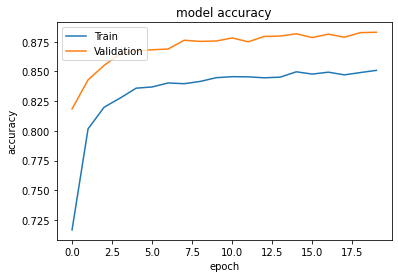

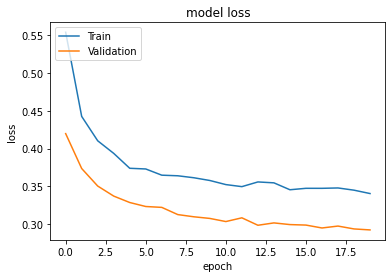

In [18]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Loss')
plt.show()

## Test the model 

In [19]:
test_model=tuple(np.array(test_d))
test_model_val=np.array(test_df['value'].values)

In [20]:
a=model.predict(test_model)

In [21]:
i=0
j=0
for k in range (len(a)):
    if a[k]>0.5 and test_model_val[k]==1:
        i=i+1
    elif a[k]<0.5 and test_model_val[k]==0:
        i=i+1
    elif a[k]>0.5 and test_model_val[k]==0:
        j=j+1
    elif a[k]<0.5 and test_model_val[k]==1:
        j=j+1
print('the model has {} good answers'.format(i))
print('the model has {} bad answers'.format(j))
print('The accuracy is {}'.format(i/(i+j)))


the model has 1515 good answers
the model has 215 bad answers
The accuracy is 0.8757225433526011
